<a href="https://colab.research.google.com/github/Michells13/MCV/blob/main/BagofVisualWords_executed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bag Of Visual Words - Week 1


---


## Team 5 
*   Iñigo Auzmendi
*   Pierre Lammers
*   Michell Vargas


---


# Content


1.   Data management 
 *   Download files
 *   Import libraries
 *   Read dataset
2.   Local Features
  *   Best step size assessment 
3.   Best Visual Words Number (cluster number)
  *   Clustering with K-Means to find the best number of visual words

4.   Classifiers 
  *   Best Parameters for KNN 
      *   Parameter options
      *   Grid search
      *   Results
  *   Best Parameters for Logistic Regression
      *   Parameter options
      *   Grid search
      *   Results
5.   Dimension reduction
    *   LDA
    *   PCA 
6.  Final test 





















# 1.- Data Management - Download files from Google Drive (Only for Google Colab)

In [ ]:
# Download files from Google Drive
!gdown "1ykWGN5eRrNrutVyGTpl9zeOyjQXdp41X&confirm=t"
!unzip MIT_split.zip -d /content/MIT_split/
%cd ./MIT_split/

### Import libraries

In [ ]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read dataset

The dataset is partitioned in train and test images. Each of the image has its own label. There are 8 different classes.

In [ ]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb')) 
test_labels = pickle.load(open('test_labels.dat','rb'))

As the assesments will be done using the cross-validation technique, train and test images has to be joined together.

In [ ]:
images_filenames = train_images_filenames + test_images_filenames

labels = train_labels + test_labels

# 2.- Local features


First, the local features have to be obtained. There are many keypoints detectors and descriptor types. In this study the following local features will be tested:


*   KAZE
*   AKAZE
*   SIFT
*   DENSE SIFT
*   ORB
*   BEBLID
*   BRISK
*   BRIEF




In [ ]:
# Dense detector class
class denseDetector:
  def __init__(self, stepSize):
    self.step_size = stepSize
  
  def detect(self, gray, a):
    kpt = [cv2.KeyPoint(x, y, self.step_size) for y in range(0, gray.shape[0], self.step_size) for x in range(0, gray.shape[1], self.step_size)]

    return kpt

In [ ]:
# Local feature types
KAZE_DETECTOR = 0
AKAZE_DETECTOR = 1
SIFT_DETECTOR = 2
DENSE_SIFT_DETECTOR = 3
ORB_DETECTOR = 4
BEBLID_DETECTOR = 5
BRISK_DETECTOR = 6
BRIEF_DETECTOR = 7


detectors = [
    [cv2.KAZE_create(threshold = 0.0001)],
    [cv2.AKAZE_create(threshold = 0.0001)],
    [cv2.SIFT_create()],
    [denseDetector(5), cv2.SIFT_create()],
    [cv2.ORB_create()],
    [cv2.ORB_create(), cv2.xfeatures2d.BEBLID_create(0.75)],
    [cv2.BRISK_create(thresh = 20)],
    [cv2.FastFeatureDetector_create(), cv2.xfeatures2d.BriefDescriptorExtractor_create()]
    ]

detectorsString = [
    "KAZE",
    "AKAZE",
    "SIFT",
    "D_SIFT",
    "ORB",
    "BEBLID",
    "BRISK",
    "BRIEF"
]

In order to test the different types of local features a simple method is going to be used:


1.   For each image, keypoints will be detected and descriptors will be generated for each keypoint.
2.   As the evaluation will be done using cross validation, the images will be divided into **5** (number of folds) groups.
3.   In each train-test partition of the 5 different folds, training set will be used to generate the visual bag. In order to do so, a clustering algorithm (with 128 clusters) will be computed using **all the local descriptors of the training images**.
4.   After computing the clusters, for each of the images (training and test images) using all the local features of each image, a global descriptor (histogram) will be generated.
5.  With the global descriptors of the training images a classifier will be trained. In this case, to keep it simple, a 3NN with *Euclidean* distance will be applied.
6.  Using the trained classifier, the global descriptors of the test images will be classfied.
7.  Using the labels provided, the evaluation of the classification accuracy will be obtained.

Steps 3-7 are done using every training-testing partition of different folds.

The optimum number of clusters and different classifiers will be discussed after trying different local features.


In order to apply the clustering method only using the training images local descriptors, a class with fit() and transform() methods needs to be implemented.

In [ ]:
class vwDictionary:
    def __init__(self, numClusters, randomState):
        
        self.num_clusters = numClusters
        self.codebook = MiniBatchKMeans(n_clusters = self.num_clusters, verbose = False, batch_size = 4096, n_init = 3,
                                        compute_labels = False, reassignment_ratio = 10**-4, random_state = randomState)
        
        
    def fit(self, X, y):

        D=np.vstack(X)
        
        # Create clusters
        self.codebook.fit(D)
        return self
        
        
    def transform(self, X):

        # Create visual words
        visual_words=np.zeros((len(X),self.num_clusters),dtype=np.float32)
        for i in range(len(X)):
            words=self.codebook.predict(X[i])
            visual_words[i,:]=np.bincount(words,minlength=self.num_clusters)
        
        return visual_words

Initial values

In [ ]:
numVisualWords = 128
numSplits = 5
randomState = 42

Compute 3-NN classifier with 128 visual words with different local descriptors types and evaluate using cross-validation.

In [ ]:
accScores = []

# Create model
visualBag = vwDictionary(numVisualWords, randomState)
knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-1,metric='euclidean')
model = Pipeline(steps = [("vw", visualBag), ("KNN", knn)])

# Partition for cross validation
stf = StratifiedKFold(n_splits=numSplits, random_state = randomState, shuffle=True)

# For each local feature type
for detectorType in range(KAZE_DETECTOR, BRIEF_DETECTOR+1):
  
  # Get local descriptors
  detector = detectors[detectorType]

  descriptors = []
  label_per_descriptor = []

  for filename,label in zip(images_filenames, labels):

      ima=cv2.imread(filename)
      gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

      if len(detector) == 1:
        kpt,des= detector[0].detectAndCompute(gray,None)
    
      else:
        kpt = detector[0].detect(gray,None)
        kpt, des  = detector[1].compute(gray,kpt)

      descriptors.append(des)
      label_per_descriptor.append(label)

  # Apply model
  scores = cross_val_score(estimator = model, X = descriptors, y = label_per_descriptor, cv = stf, n_jobs = 2)

  # Print values
  print(detectorsString[detectorType])
  print("Mean: ", 100*scores.mean())
  print("Std: ", 100*scores.std())
  print("--------------------")

  # Store values
  accScores.append([score*100 for score in scores])

KAZE
Mean:  55.17109371214166
Std:  0.9279060062522375
--------------------
AKAZE
Mean:  44.19589762760205
Std:  1.2516214968734347
--------------------
SIFT
Mean:  55.8789364014593
Std:  2.1100747637581474
--------------------
D_SIFT
Mean:  71.6900306674143
Std:  1.9380566150994507
--------------------
ORB
Mean:  29.42694163499547
Std:  1.0027843786534438
--------------------
BEBLID
Mean:  33.74273985310101
Std:  0.7477816707295885
--------------------
BRISK
Mean:  45.42377105356067
Std:  2.624004799892132
--------------------
BRIEF
Mean:  60.49178625573717
Std:  1.8308675741355556
--------------------


Plot boxplot with different local descriptors:

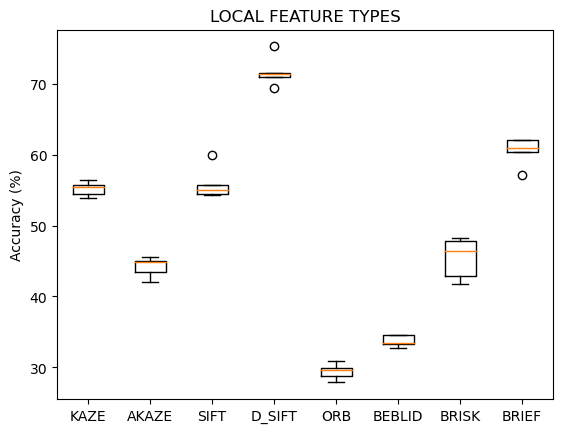

In [ ]:
from matplotlib import pyplot as plt

plt.title("LOCAL FEATURE TYPES")
plt.ylabel("Accuracy (%)")
plt.boxplot(accScores, labels = detectorsString)
plt.show()

The graph shows that the **Dense SIFT** is the best local descriptor type. The performance difference between SIFT and Dense SIFT shows that the SIFT keypoint detector is not detecting important keypoints, and the lost information is negatively affecting the classification task. The low performance of AKAZE, ORB, BEBLID and BRISK is expected due to the fact that the descriptors they use are binary, so the clustering method does not have much information. However, it is impressive that BRIEF, despite having binary descriptors, outperforms SIFT and KAZE local features in this task.

### Best step size

As Dense SIFT is the best local feature type, the best step size for the dense detector need to found. The smaller is the step size the more keypoints will be obtained.

In order to get the best step size, the same process will be computed, changing the step size of the dense detector in each iteration.

In [ ]:
step_range = range(4,65,2) # Below 4 not enough RAM

In [ ]:
accScores = []

# Create model
visualBag = vwDictionary(numVisualWords, randomState)
knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-1,metric='euclidean')
model = Pipeline(steps = [("vw", visualBag), ("knn", knn)])

# Partition for cross validation
stf = StratifiedKFold(n_splits=numSplits, random_state = randomState, shuffle=True)

detector = [None, cv2.SIFT_create()]

for step_size in step_range:

  detector[0] = denseDetector(step_size)

  descriptors = []
  label_per_descriptor = []

  for filename,label in zip(images_filenames, labels):

      ima=cv2.imread(filename)
      gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

      if len(detector) == 1:
        kpt,des= detector[0].detectAndCompute(gray,None)
    
      else:
        kpt = detector[0].detect(gray,None)
        kpt, des  = detector[1].compute(gray,kpt)

      descriptors.append(des)
      label_per_descriptor.append(label)

  scores = cross_val_score(estimator = model, X = descriptors, y = label_per_descriptor, cv = stf, n_jobs = 2)

  # Print values
  print("Step size: ", step_size)
  print("Mean: ", 100*scores.mean())
  print("Std: ", 100*scores.std())
  print("--------------------")

  # Store values
  accScores.append([score*100 for score in scores])

Step size:  4
Mean:  71.65167909285373
Std:  0.8560213656520343
--------------------
Step size:  6
Mean:  72.24744380525154
Std:  0.8453004716574484
--------------------
Step size:  8
Mean:  74.18156770714349
Std:  1.9863092426608713
--------------------
Step size:  10
Mean:  75.18597744595128
Std:  1.4528253409384235
--------------------
Step size:  12
Mean:  74.81423023405537
Std:  0.908317564094759
--------------------
Step size:  14
Mean:  74.73884239164296
Std:  1.182458986420428
--------------------
Step size:  16
Mean:  74.66490830927707
Std:  1.363141625034529
--------------------
Step size:  18
Mean:  74.88857967643455
Std:  0.6884072252352346
--------------------
Step size:  20
Mean:  73.88520833765999
Std:  1.4109421150495998
--------------------
Step size:  22
Mean:  73.69926550504317
Std:  2.445663499945509
--------------------
Step size:  24
Mean:  72.17337126954789
Std:  1.4992225411019404
--------------------
Step size:  26
Mean:  71.57906031719659
Std:  2.2280483993703

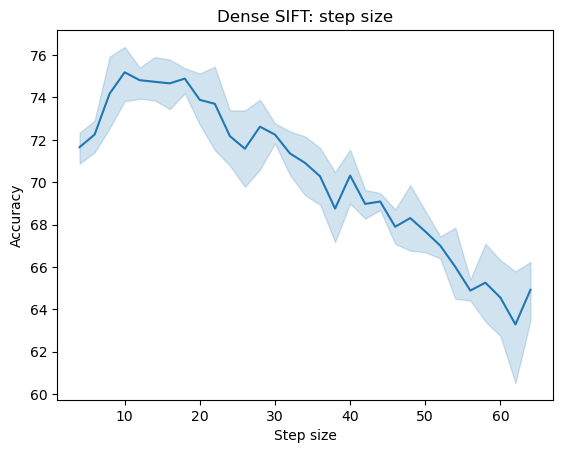

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the pandas DataFrame
listData = []
for i, step in enumerate(step_range):
  for j in range(len(accScores[0])):

    listData.append([accScores[i][j], step])


df = pd.DataFrame(listData, columns = ["Accuracy", "Step size"])

sns.lineplot(data = df, x = "Step size", y = "Accuracy")
plt.title("Dense SIFT: step size")
plt.show()

The graph shows that with low step sizes such as 4 or 8 the results obtained are not optimal. This can be caused by the too redundant information generated by too many closely spaced keypoints. It can also be seen that the accuracy drops when the step size is too large. The bigger the step size, the fewer keypoints are considered, so very large step sizes result in too few keypoints. The testing showed that the best step size is 10.

# 3.- Best visual words number (cluster number)

After obtaining the local features, a global descriptor must be created for each image. To do this, a bag of visual words is created using the local features of the training set. The K-Means algorithm is used to group all the local features into a fixed number of clusters. The number of clusters is a parameter that must be set, so different values must be tested.





Since the best local feature type and the best step size are known, all the local features can be computed at once.

In [ ]:
bestStepSize = 10
detector = [denseDetector(bestStepSize), cv2.SIFT_create()]

descriptors = []
label_per_descriptor = []

for filename,label in zip(images_filenames, labels):

    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    if len(detector) == 1:
      kpt,des= detector[0].detectAndCompute(gray,None)
  
    else:
      kpt = detector[0].detect(gray,None)
      kpt, des  = detector[1].compute(gray,kpt)

    descriptors.append(des)
    label_per_descriptor.append(label)

### Clustering using K-Means to find the best number of visual words




Once the local features are computed, different numbers of visual words (clusters) will be tested. In this case, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, and 4096 will be tested as the number of visual words.

In [ ]:
a=1 #Initial 
b=13 #Final 
range_vis = [2**i for i in range(a,b)]
accScores = []

# Classifier
knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-1,metric='euclidean')

# Partition for cross validation
stf = StratifiedKFold(n_splits=numSplits, random_state = randomState, shuffle=True)

for numVisualWords in range_vis:
    
  # Create model
  visualBag = vwDictionary(numVisualWords, randomState)
  model = Pipeline(steps = [("vw", visualBag), ("knn", knn)])
  
  scores = cross_val_score(estimator = model, X = descriptors, y = label_per_descriptor, cv = stf, n_jobs = 2)

  # Print values
  print("VisualWords: ", numVisualWords)
  print("Mean: ", 100*scores.mean())
  print("Std: ", 100*scores.std())
  print("--------------------")
  # Store values
  accScores.append([score*100 for score in scores])

VisualWords:  2
Mean:  27.679175925733627
Std:  1.486687697193187
--------------------
VisualWords:  4
Mean:  40.95968931071006
Std:  6.216535832087832
--------------------
VisualWords:  8
Mean:  60.081687469280666
Std:  1.428633343641613
--------------------
VisualWords:  16
Mean:  64.21271970814037
Std:  2.3344719943847765
--------------------
VisualWords:  32
Mean:  68.11717305974953
Std:  1.3421651780560984
--------------------
VisualWords:  64
Mean:  72.87913715879905
Std:  1.2754661666892022
--------------------
VisualWords:  128
Mean:  75.18597744595128
Std:  1.4528253409384235
--------------------
VisualWords:  256
Mean:  74.40572366098316
Std:  1.3047507799190996
--------------------
VisualWords:  512
Mean:  74.40530830096986
Std:  2.1251726122479484
--------------------
VisualWords:  1024
Mean:  73.10204703259883
Std:  1.3358168851471575
--------------------
VisualWords:  2048
Mean:  71.20447481187652
Std:  1.3623702379448088
--------------------
VisualWords:  4096
Mean:  67.

Plot results


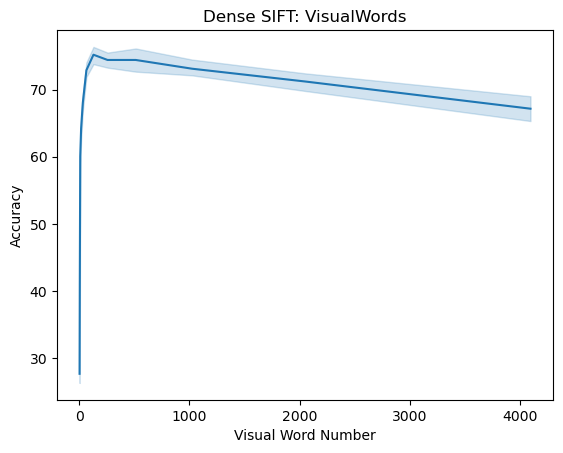

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the pandas DataFrame
listData = []
for i, step in enumerate(range_vis):
  for j in range(len(accScores[0])):

    listData.append([accScores[i][j], step])


df = pd.DataFrame(listData, columns = ["Accuracy", "Visual Word Number"])

sns.lineplot(data = df, x = "Visual Word Number", y = "Accuracy")
plt.title("Dense SIFT: VisualWords")
plt.show()

The graph shows that with too small number of visual words (e.g. 2, 4, or 8), the results are not very good. This is because it is difficult for the classifier to distinguish between the 8 classes of the dataset with such a small number of clusters. On the other hand, it can also be seen that with a very large number of clusters such as 2048 or 4096, the results are also not optimal. This is because a high-dimensional, very large number of visual words results in sparse global descriptors for the images, making them difficult to classify. However, an intermediate number of visual words, such as 128, resulted in the best results.

# 4.- Classifiers

Up to this point, the default 3NN classifier has been used. However, more powerful classifiers such as logistic regression should also be tested. In addition, the best hyperparameters for KNN and logistic regression should be determined.

## 4.1.- Best parameters for KNN

In [ ]:
bestVisualWordNumber = 128

The most important parameter of KNN is the number of neighbors (K) used to classify. Additionally, the distance metric is also an important parameter. This distance can also be used as weights in the classification step.

### Parameter options:

In this study, a range from 1 to 60 (with jumps of 2) values of k will be tested.

For the distance metric, the most common distances will be used: Manhattan, Euclidean, Cosine, Chebyshev, Canberra, and Correlation.

Finally, a parameter will be set to indicate if the distances will be used as weights or not. For that purpose, the *weights* parameter will have one of these values:

* 'uniform': uniform weights. All points in each neighborhood are weighted equally.
* 'distance': weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors that are further away.

In [ ]:
k_range = range(1,61,2)
weight_options = ['uniform', 'distance']
distance_formulas = ["manhattan", "euclidean", "cosine", "chebyshev", "canberra", "correlation"]
param_grid = dict(knn__n_neighbors=k_range, knn__weights=weight_options, knn__metric = distance_formulas)

### Grid search (360 candidates):

In order to find the best parameters, a grid search is defined. This search will test the 360 combinations of different parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create model
visualBag = vwDictionary(bestVisualWordNumber, randomState)
knn = KNeighborsClassifier(n_jobs = -1)
model = Pipeline(steps = [("vw", visualBag), ("knn", knn)])

# Partition for cross validation
stf = StratifiedKFold(n_splits=numSplits, random_state = randomState, shuffle=True)

rs = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, cv= stf, verbose=5)

results = rs.fit(X = descriptors, y = label_per_descriptor)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


### Results:

In [ ]:
print(results.best_score_)
print(results.best_params_)

0.8098924909832264
{'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}


The best results were obtained using the manhattan distance, and with k = 9. In addition, using the distance as a weight improved the results. Therefore, with the best hyperparameters for the KNN classifier, the mean accuracy obtained was **80.99%**.

In [ ]:
bestKNN = KNeighborsClassifier(n_neighbors = 9, weights = 'distance', metric = "manhattan")

## 4.2- Best parameters for logistic regression:

In [ ]:
bestVisualWordNumber = 128

The most important parameters of logistic regression are C and the solver. C is the inverse of the regularization strength; the smaller this value is, the stronger the regularization. The solver is the algorithm used to solve the optimization problem.

### Parameter options

As for C, 20 different values from 0.0001 to 10000 will be tested. For the solver, the 5 most popular algorithms will be used.

In [ ]:
classifier__C = np.logspace(-4, 4, 20)
random_state = [ randomState ]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
multiclass = ["auto"]
max_iter = [10000]


param_grid = dict(lr__C=classifier__C, lr__random_state=random_state, lr__solver = solvers, lr__multi_class=multiclass)

### Grid search (100 candidates)

In order to find the best parameters, a grid search is defined. This search will test the 100 combinations of different parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create model
visualBag = vwDictionary(bestVisualWordNumber, randomState)
lr = LogisticRegression(n_jobs=-1)
model = Pipeline(steps = [("vw", visualBag), ("lr", lr)])

# Partition for cross validation
stf = StratifiedKFold(n_splits=numSplits, random_state = randomState, shuffle=True)


rs = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, cv= stf, verbose=5)

results = rs.fit(X = descriptors, y = label_per_descriptor)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


### Results

In [ ]:
print(results.best_score_)
print(results.best_params_)

0.8307380255169502
{'lr__C': 0.00026366508987303583, 'lr__multi_class': 'auto', 'lr__random_state': 42, 'lr__solver': 'newton-cg'}


The best results were obtained using a high regularization value (inverse value of *0.00026366508987303583*) and with the *Newton-CG* solver algorithm. Therefore, with the best hyperparameters of the logistic regression classifier the mean accuracy value obtained is **83.07%**.

In [ ]:
bestLR = LogisticRegression(C = 0.0018329807108324356, multi_class = "auto", random_state = randomState, solver = "newton-cg", n_jobs=-1)

# 5.- Dimension reduction

Sometimes, the redundancy of the data can make it difficult to correctly classify the images. Therefore, some dimension reduction algorithms such as LDA or PCA will be tested. These methods will reduce the dimensions of the visual words of each image while retaining the most important data and removing the most redundant information.

As the logistic regression was the best classifier, this is the one that will be used in this test.

In [ ]:
bestLR = LogisticRegression(C = 0.0018329807108324356, multi_class = "auto", random_state = randomState, solver = "newton-cg", n_jobs=-1)

### LDA

Linear Discriminant Analysis is a classifier with a linear decision boundary, generated by fitting class-conditional densities to the data and using Bayes' rule. The only parameter that needs to be set is the number of components, which must be in the range of 1 and the number of classes - 1.

In [ ]:
num_classes = 8
n_components = range(1,num_classes)

Different number of components were tested.

In [ ]:
accScores = []
maxScore = -1
bestValue = None

# Create model
visualBag = vwDictionary(bestVisualWordNumber, randomState)


# Partition for cross validation
stf = StratifiedKFold(n_splits=numSplits, random_state = randomState, shuffle=True)

for n in n_components:
    
    model = Pipeline(steps = [("vw", visualBag), ('lda', LinearDiscriminantAnalysis(n_components=n)), ("lr", bestLR)])
    
    scores = cross_val_score(estimator = model, X = descriptors, y = label_per_descriptor, cv = stf, n_jobs = -1)

    # Print values
    print("Component number: ", n)
    print("Mean: ", 100*scores.mean())
    print("Std: ", 100*scores.std())
    print("--------------------")
    
    
    accScores.append([score*100 for score in scores])
    
    if 100*scores.mean()>maxScore:
        maxScore = 100*scores.mean()
        bestValue = n

print("Best LDA component number: ", bestValue, " Mean accuracy: ", maxScore)

Component number:  1
Mean:  31.881857766886114
Std:  1.9349481391054346
--------------------
Component number:  2
Mean:  52.82770174381979
Std:  1.4936410087468306
--------------------
Component number:  3
Mean:  67.41106103715396
Std:  1.1275443723221525
--------------------
Component number:  4
Mean:  77.60420344333451
Std:  1.0875457772240427
--------------------
Component number:  5
Mean:  79.20444712120897
Std:  1.1140961345491722
--------------------
Component number:  6
Mean:  78.94443175288849
Std:  1.358707571148468
--------------------
Component number:  7
Mean:  80.95290509715963
Std:  1.7444033143704147
--------------------
Best LDA component number:  7  Mean accuracy:  80.95290509715963


Plot results

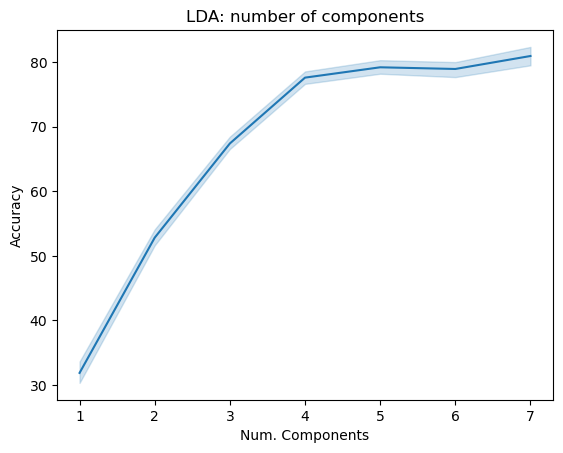

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the pandas DataFrame
listData = []
for i, step in enumerate(n_components):
  for j in range(len(accScores[0])):

    listData.append([accScores[i][j], step])


df = pd.DataFrame(listData, columns = ["Accuracy", "Num. Components"])

sns.lineplot(data = df, x = "Num. Components", y = "Accuracy")
plt.title("LDA: number of components")
plt.show()

It can be seen that with only 4 components very good results were obtained. This can be used for speed up purposes not affecting too much to the accuracy. However, in this test the speed is not the aim and it was not improved the mean accuracy values using any component number. This can be caused by the fact that the all 128 values of the visual words are quite important.

### PCA

Principal component analysis is a linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD. The only parameter of this method is the number of components that have to be in the range of 1 to the number of dimensions of the data (128 in this case).

In [ ]:
n_components = range(1, bestVisualWordNumber)

Different number of components were tested.

In [ ]:
accScores = []
maxScore = -1
bestValue = None

# Create model
visualBag = vwDictionary(bestVisualWordNumber, randomState)


# Partition for cross validation
stf = StratifiedKFold(n_splits=numSplits, random_state = randomState, shuffle=True)

for n in n_components:
    
    model = Pipeline(steps = [("vw", visualBag), ('pca', PCA(n_components=n)), ("lr", bestLR)])
    
    scores = cross_val_score(estimator = model, X = descriptors, y = label_per_descriptor, cv = stf, n_jobs = -1)

    # Print values
    print("Component number: ", n)
    print("Mean: ", 100*scores.mean())
    print("Std: ", 100*scores.std())
    print("--------------------")
    
    
    accScores.append([score*100 for score in scores])
    
    if 100*scores.mean()>maxScore:
        maxScore = 100*scores.mean()
        bestValue = n

print("Best PCA component number: ", bestValue, " Mean accuracy: ", maxScore)

Component number:  1
Mean:  34.59748153378607
Std:  1.2076229660243005
--------------------
Component number:  2
Mean:  58.036385537164335
Std:  0.8994146537230102
--------------------
Component number:  3
Mean:  65.55087121762789
Std:  1.0851505602079792
--------------------
Component number:  4
Mean:  69.30724872449862
Std:  1.8558804819020933
--------------------
Component number:  5
Mean:  70.57229687164683
Std:  1.5303544606927952
--------------------
Component number:  6
Mean:  72.65581192498598
Std:  1.5783267872302447
--------------------
Component number:  7
Mean:  72.95307124116495
Std:  2.017486368851471
--------------------
Component number:  8
Mean:  73.73470955951069
Std:  1.639800631200752
--------------------
Component number:  9
Mean:  74.55345337237718
Std:  1.2110874342401
--------------------
Component number:  10
Mean:  74.81436868739313
Std:  1.0864634070126096
--------------------
Component number:  11
Mean:  75.14921808477497
Std:  1.295250022149565
------------

Component number:  90
Mean:  82.51604328051337
Std:  1.7918516611558462
--------------------
Component number:  91
Mean:  82.36720594241724
Std:  1.6489410120002812
--------------------
Component number:  92
Mean:  82.55335645504074
Std:  1.7336696286804756
--------------------
Component number:  93
Mean:  82.25561255217958
Std:  1.5368448435858386
--------------------
Component number:  94
Mean:  82.59039272289257
Std:  1.6502359935287727
--------------------
Component number:  95
Mean:  82.40438066360683
Std:  1.4916954257725068
--------------------
Component number:  96
Mean:  82.25533564550406
Std:  1.2413172886039796
--------------------
Component number:  97
Mean:  82.1438114819353
Std:  1.3944233006418054
--------------------
Component number:  98
Mean:  81.99511259717693
Std:  1.4486026658915783
--------------------
Component number:  99
Mean:  82.4041729836002
Std:  1.3008655320513485
--------------------
Component number:  100
Mean:  82.4787993326549
Std:  1.5893776884786488


Plot results

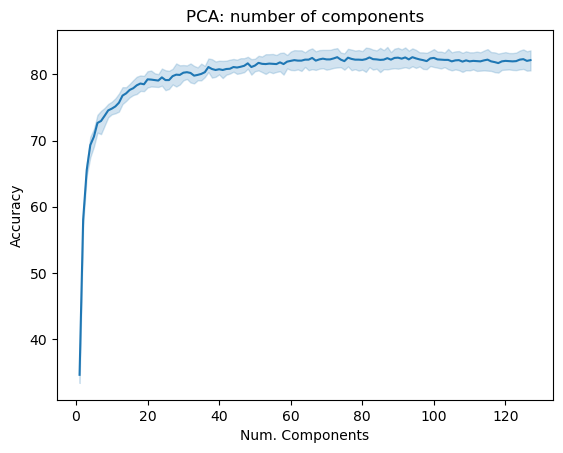

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the pandas DataFrame
listData = []
for i, step in enumerate(n_components):
  for j in range(len(accScores[0])):

    listData.append([accScores[i][j], step])


df = pd.DataFrame(listData, columns = ["Accuracy", "Num. Components"])

sns.lineplot(data = df, x = "Num. Components", y = "Accuracy")
plt.title("PCA: number of components")
plt.show()

It can be seen that with 94 components very good results were obtained (**82%**). As in the LDA case, it can be used for speed up purposes not affecting too much to the accuracy. However, it was not improved the accuracy value with any of the components reductions. 

# 6.- Final test

After all the testing evaluated with 5 fold cross validation, these are the best options:


*   Best local features obtained with **Dense SIFT with 10 step size**
*   Visual words best number **128**
*   Best classifier: logistic regression, with Newton-CG solver and high regularization
*   No dimensional reduction

Using this pipeline with the best parameters, a classifier will be trained with the original training images and the test set will be predicted.



In [ ]:
bestStepSize = 10
bestVisualWordNumber = 128

# Detector
detector = [denseDetector(bestStepSize), cv2.SIFT_create()]

# Create model
visualBag = vwDictionary(bestVisualWordNumber, randomState)
bestLR = LogisticRegression(C = 0.0018329807108324356, multi_class = "auto", random_state = randomState, solver = "newton-cg", n_jobs=-1)


# Generate descriptors

# Training images
train_descriptors = []
train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    kpt = detector[0].detect(gray,None)
    kpt, des  = detector[1].compute(gray,kpt)
    
    train_descriptors.append(des)
    train_label_per_descriptor.append(labels)


# Test images
test_descriptors = []
test_label_per_descriptor = []

for filename,labels in zip(test_images_filenames,test_labels):
    
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    kpt = detector[0].detect(gray,None)
    kpt, des  = detector[1].compute(gray,kpt)
    
    test_descriptors.append(des)
    test_label_per_descriptor.append(labels)


# Clustering with training image local features
visualBag = visualBag.fit(train_descriptors, train_label_per_descriptor)

# Get visual words
visualWords_train = visualBag.transform(train_descriptors)
visualWords_test = visualBag.transform(test_descriptors)

# Train model
bestLR.fit(visualWords_train, train_label_per_descriptor)

# Predict test images
accuracy = 100*bestLR.score(visualWords_test, test_label_per_descriptor)
print("Test set accuracy: ", accuracy)

Test set accuracy:  82.77571251548946


The final test accuracy obtained is **82.78%**. This is a very good result taking into account that only classical methods were used, leaving aside the neural networks.